# Problem Statement

Each season there are thousands of NCAA basketball games played between Division I men's teams, culminating in March Madness®, the 68-team national championship that starts in the middle of March. We have provided a large amount of historical data about college basketball games and teams, going back many years. Armed with this historical data, you can explore it and develop your own distinctive ways of predicting March Madness® game outcomes. You can even evaluate and compare different approaches by seeing which of them would have done best at predicting tournament games from the past.


## What to Predict
Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA® tournaments (2014-2017).

Stage 2 - You should submit predicted probabilities for every possible matchup before the 2018 tournament begins.

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 20)
pd.set_option('expand_frame_repr', False)
pd.options.display.max_rows = 9999

plt.style.use('seaborn-whitegrid')

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
rnd_seed=23
np.random.seed(rnd_seed)

## Data Section 1 - The Basics

**This section provides everything you need to build a simple prediction model and submit predictions.**

- Team ID's and Team Names
- Tournament seeds since 1984-85 season
- Final scores of all regular season, conference tournament, and NCAA® tournament games since 1984-85 season
- Season-level details including dates and region names
- Example submission file for stage 1

### Preview Data

In [4]:
teams = pd.read_csv('DataFiles/Teams.csv')
seasons = pd.read_csv('DataFiles/Seasons.csv')
seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
reg_results = pd.read_csv('DataFiles/RegularSeasonCompactResults.csv')
tourn_results = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')

In [5]:
teams.head()
seasons.head()
seeds.head()
reg_results.head()
tourn_results.head()
ball_data = [teams, seasons, seeds, reg_results, tourn_results]

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [6]:
# Check for null values
info=list(map(lambda x: x.info(), ball_data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 4 columns):
TeamID           364 non-null int64
TeamName         364 non-null object
FirstD1Season    364 non-null int64
LastD1Season     364 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
Season     34 non-null int64
DayZero    34 non-null object
RegionW    34 non-null object
RegionX    34 non-null object
RegionY    34 non-null object
RegionZ    34 non-null object
dtypes: int64(1), object(5)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 3 columns):
Season    2150 non-null int64
Seed      2150 non-null object
TeamID    2150 non-null int64
dtypes: int64(2), object(1)
memory usage: 50.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150684 entries, 0 to 150683
Data columns (total 8 columns):
Season     

In [7]:
# Describe Data
info=list(map(lambda x: x.describe(), ball_data))
for i in info:
    print(i)

            TeamID  FirstD1Season  LastD1Season
count   364.000000     364.000000    364.000000
mean   1282.500000    1988.192308   2017.184066
std     105.221988       7.126666      4.573449
min    1101.000000    1985.000000   1985.000000
25%    1191.750000    1985.000000   2018.000000
50%    1282.500000    1985.000000   2018.000000
75%    1373.250000    1985.000000   2018.000000
max    1464.000000    2014.000000   2018.000000
            Season
count    34.000000
mean   2001.500000
std       9.958246
min    1985.000000
25%    1993.250000
50%    2001.500000
75%    2009.750000
max    2018.000000
            Season       TeamID
count  2150.000000  2150.000000
mean   2001.190233  1291.615814
std       9.563269   103.292788
min    1985.000000  1102.000000
25%    1993.000000  1208.000000
50%    2001.000000  1286.500000
75%    2010.000000  1387.000000
max    2017.000000  1463.000000
              Season         DayNum        WTeamID         WScore        LTeamID         LScore          NumO

Some columns such as TeamID don't make sense to use .describe(), however columns like WScore, LScore could provide us some insight

There are 351 teams currently in Division-I, and an overall total of 364 teams in our team listing (each year, some teams might start being Division-I programs, and others might stop being Division-I programs). 

In [8]:
# how long each team stayed d1 
teams['Length']=teams['LastD1Season']-teams['FirstD1Season']
(teams.sort_values(by='Length', ascending=False)).head()

,TeamID,TeamName,FirstD1Season,LastD1Season,Length
182,1283,Missouri St,1985,2018,33
224,1325,Ohio,1985,2018,33
232,1333,Oregon St,1985,2018,33
231,1332,Oregon,1985,2018,33
230,1331,Oral Roberts,1985,2018,33


Division 1 schools are typically the largest universities, and compete in a minimum of 14 sports for both males and females. These schools often have world-class facilities, attract the top athletes in the country, and receive the most media attention.

Division 2 schools are smaller than D1 schools, and student athletes usually finance their education with a combination of athletic and educational scholarships.

Division 3 schools are the smallest of the NCAA institutions. D3 schools are not allowed to offer athletic scholarships.

### Exploratory Data Analysis


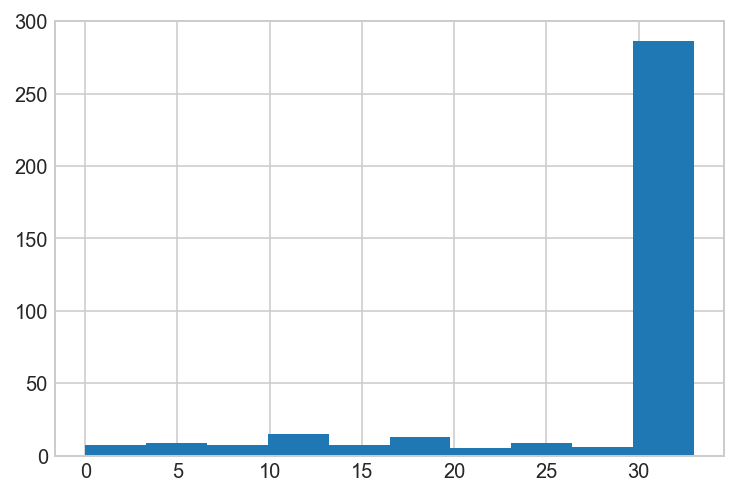

In [9]:
# Can conclude most NCAA winners are D1 teams 
teams['Length'].hist(grid=True);

**RegionW, RegionX, Region Y, Region Z** - by convention, the four regions in the final tournament are always named W, X, Y, and Z. Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. This allows us to identify the regions and brackets in a standardized way in other files. For instance, during the 2012 tournament, the four regions were East, Midwest, South, and West. Being the first alphabetically, East becomes W. Since the East regional champion (Ohio State) played against the Midwest regional champion (Kansas) in the national semifinals, that makes Midwest be region X. For the other two (South and West), since South comes first alphabetically, that makes South Y and therefore West is Z. So for that season, the W/X/Y/Z are East,Midwest,South,West.

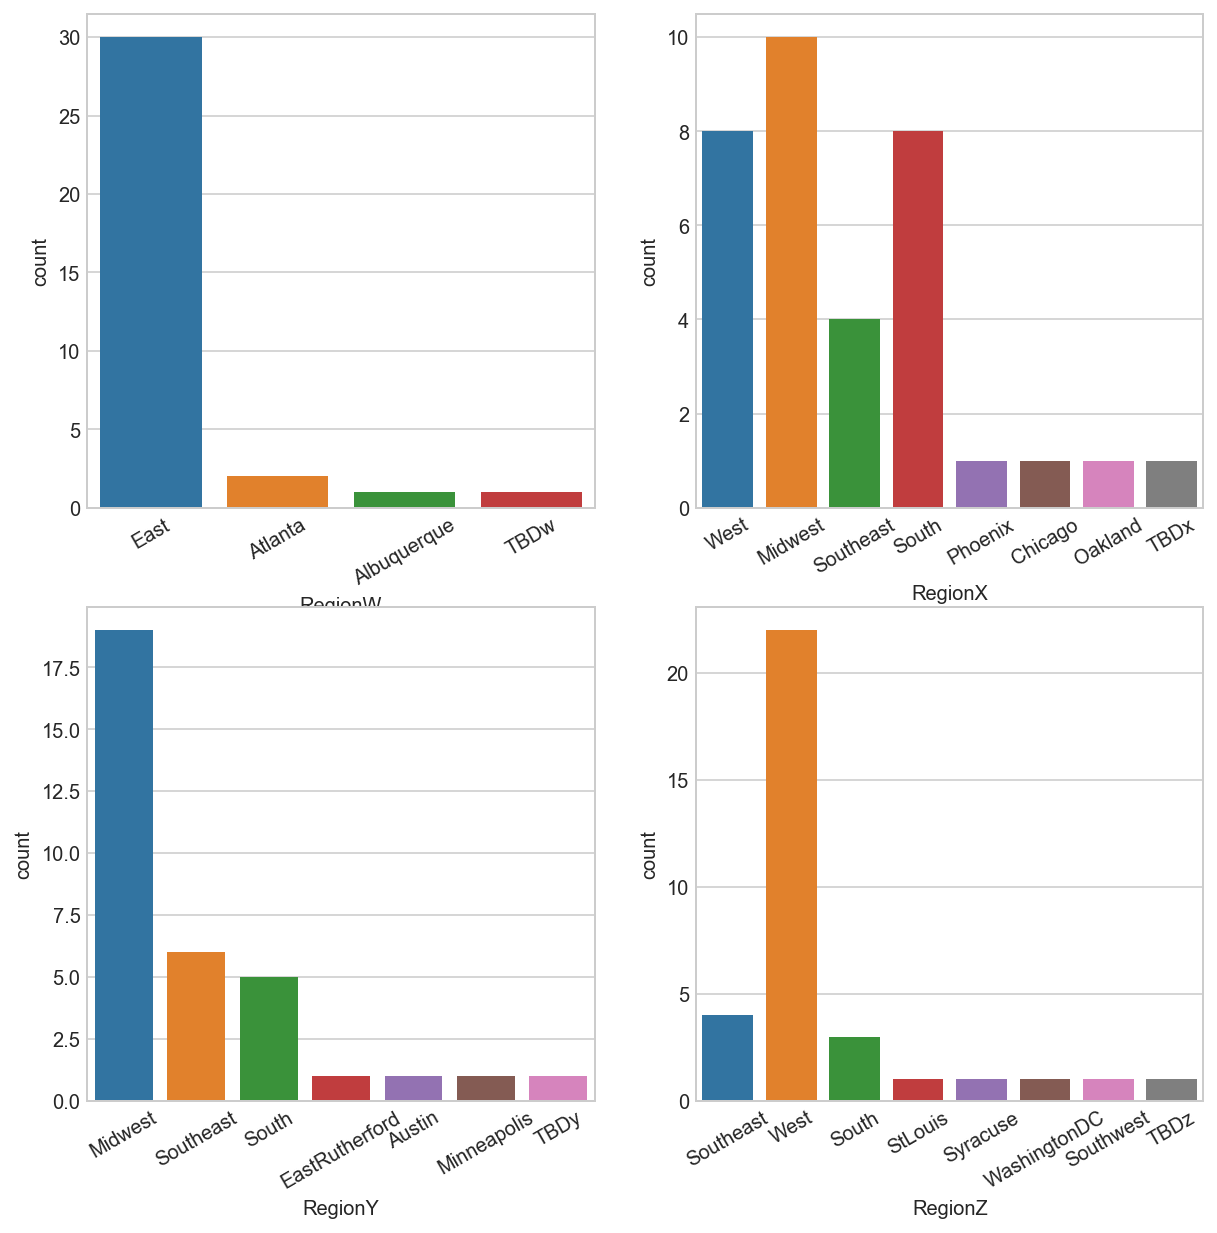

In [10]:
# Seasons
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.countplot(x='RegionW', data=seasons)
plt.xticks(rotation=30)
plt.subplot(222)
sns.countplot(x='RegionX', data=seasons)
plt.xticks(rotation=30)
plt.subplot(223)
sns.countplot(x='RegionY', data=seasons)
plt.xticks(rotation=30)
plt.subplot(224)
s=sns.countplot(x='RegionZ', data=seasons)
plt.xticks(rotation=30);

In [11]:
# merge seasons['TeamId'] with Teams['TeamId'] then merge seed with region
team_history=(seeds.merge(teams,on='TeamID')).merge(seasons,on='Season')
team_history.head()

,Season,Seed,TeamID,TeamName,FirstD1Season,LastD1Season,Length,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,W01,1207,Georgetown,1985,2018,33,10/29/1984,East,West,Midwest,Southeast
1,1985,W02,1210,Georgia Tech,1985,2018,33,10/29/1984,East,West,Midwest,Southeast
2,1985,W03,1228,Illinois,1985,2018,33,10/29/1984,East,West,Midwest,Southeast
3,1985,W04,1260,Loyola-Chicago,1985,2018,33,10/29/1984,East,West,Midwest,Southeast
4,1985,W05,1374,SMU,1985,2018,33,10/29/1984,East,West,Midwest,Southeast


**Assign one region to each row** 

In [12]:
# convert Region W, X, Y, Z into one column 
team_history.rename(index=str,columns={'RegionW':'W', 'RegionX':'X','RegionY':'Y', 'RegionZ':'Z'}, inplace=True)

In [13]:
# Find the correct region, don't need all 4 region columns
team_history['Region']=team_history.apply(lambda s: s[s['Seed'][0]], axis = 1)

In [14]:
# Only need one of the 4 columns, and DayZero just provides us when the season starts
team_history.drop(['W','X','Y','Z','DayZero'],axis=1,inplace=True)

**Assign seed value from seed to each row**

In [15]:
team_history['SeedValue'] = team_history.apply(lambda s: s['Seed'][1:], axis = 1)

In [16]:
team_history.head()

,Season,Seed,TeamID,TeamName,FirstD1Season,LastD1Season,Length,Region,SeedValue
0,1985,W01,1207,Georgetown,1985,2018,33,East,01
1,1985,W02,1210,Georgia Tech,1985,2018,33,East,02
2,1985,W03,1228,Illinois,1985,2018,33,East,03
3,1985,W04,1260,Loyola-Chicago,1985,2018,33,East,04
4,1985,W05,1374,SMU,1985,2018,33,East,05


In [17]:
team_history['SeedValue'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '16b', '16a', '11b', '12b', '11a',
       '12a', '14b', '14a', '13b', '13a'], dtype=object)

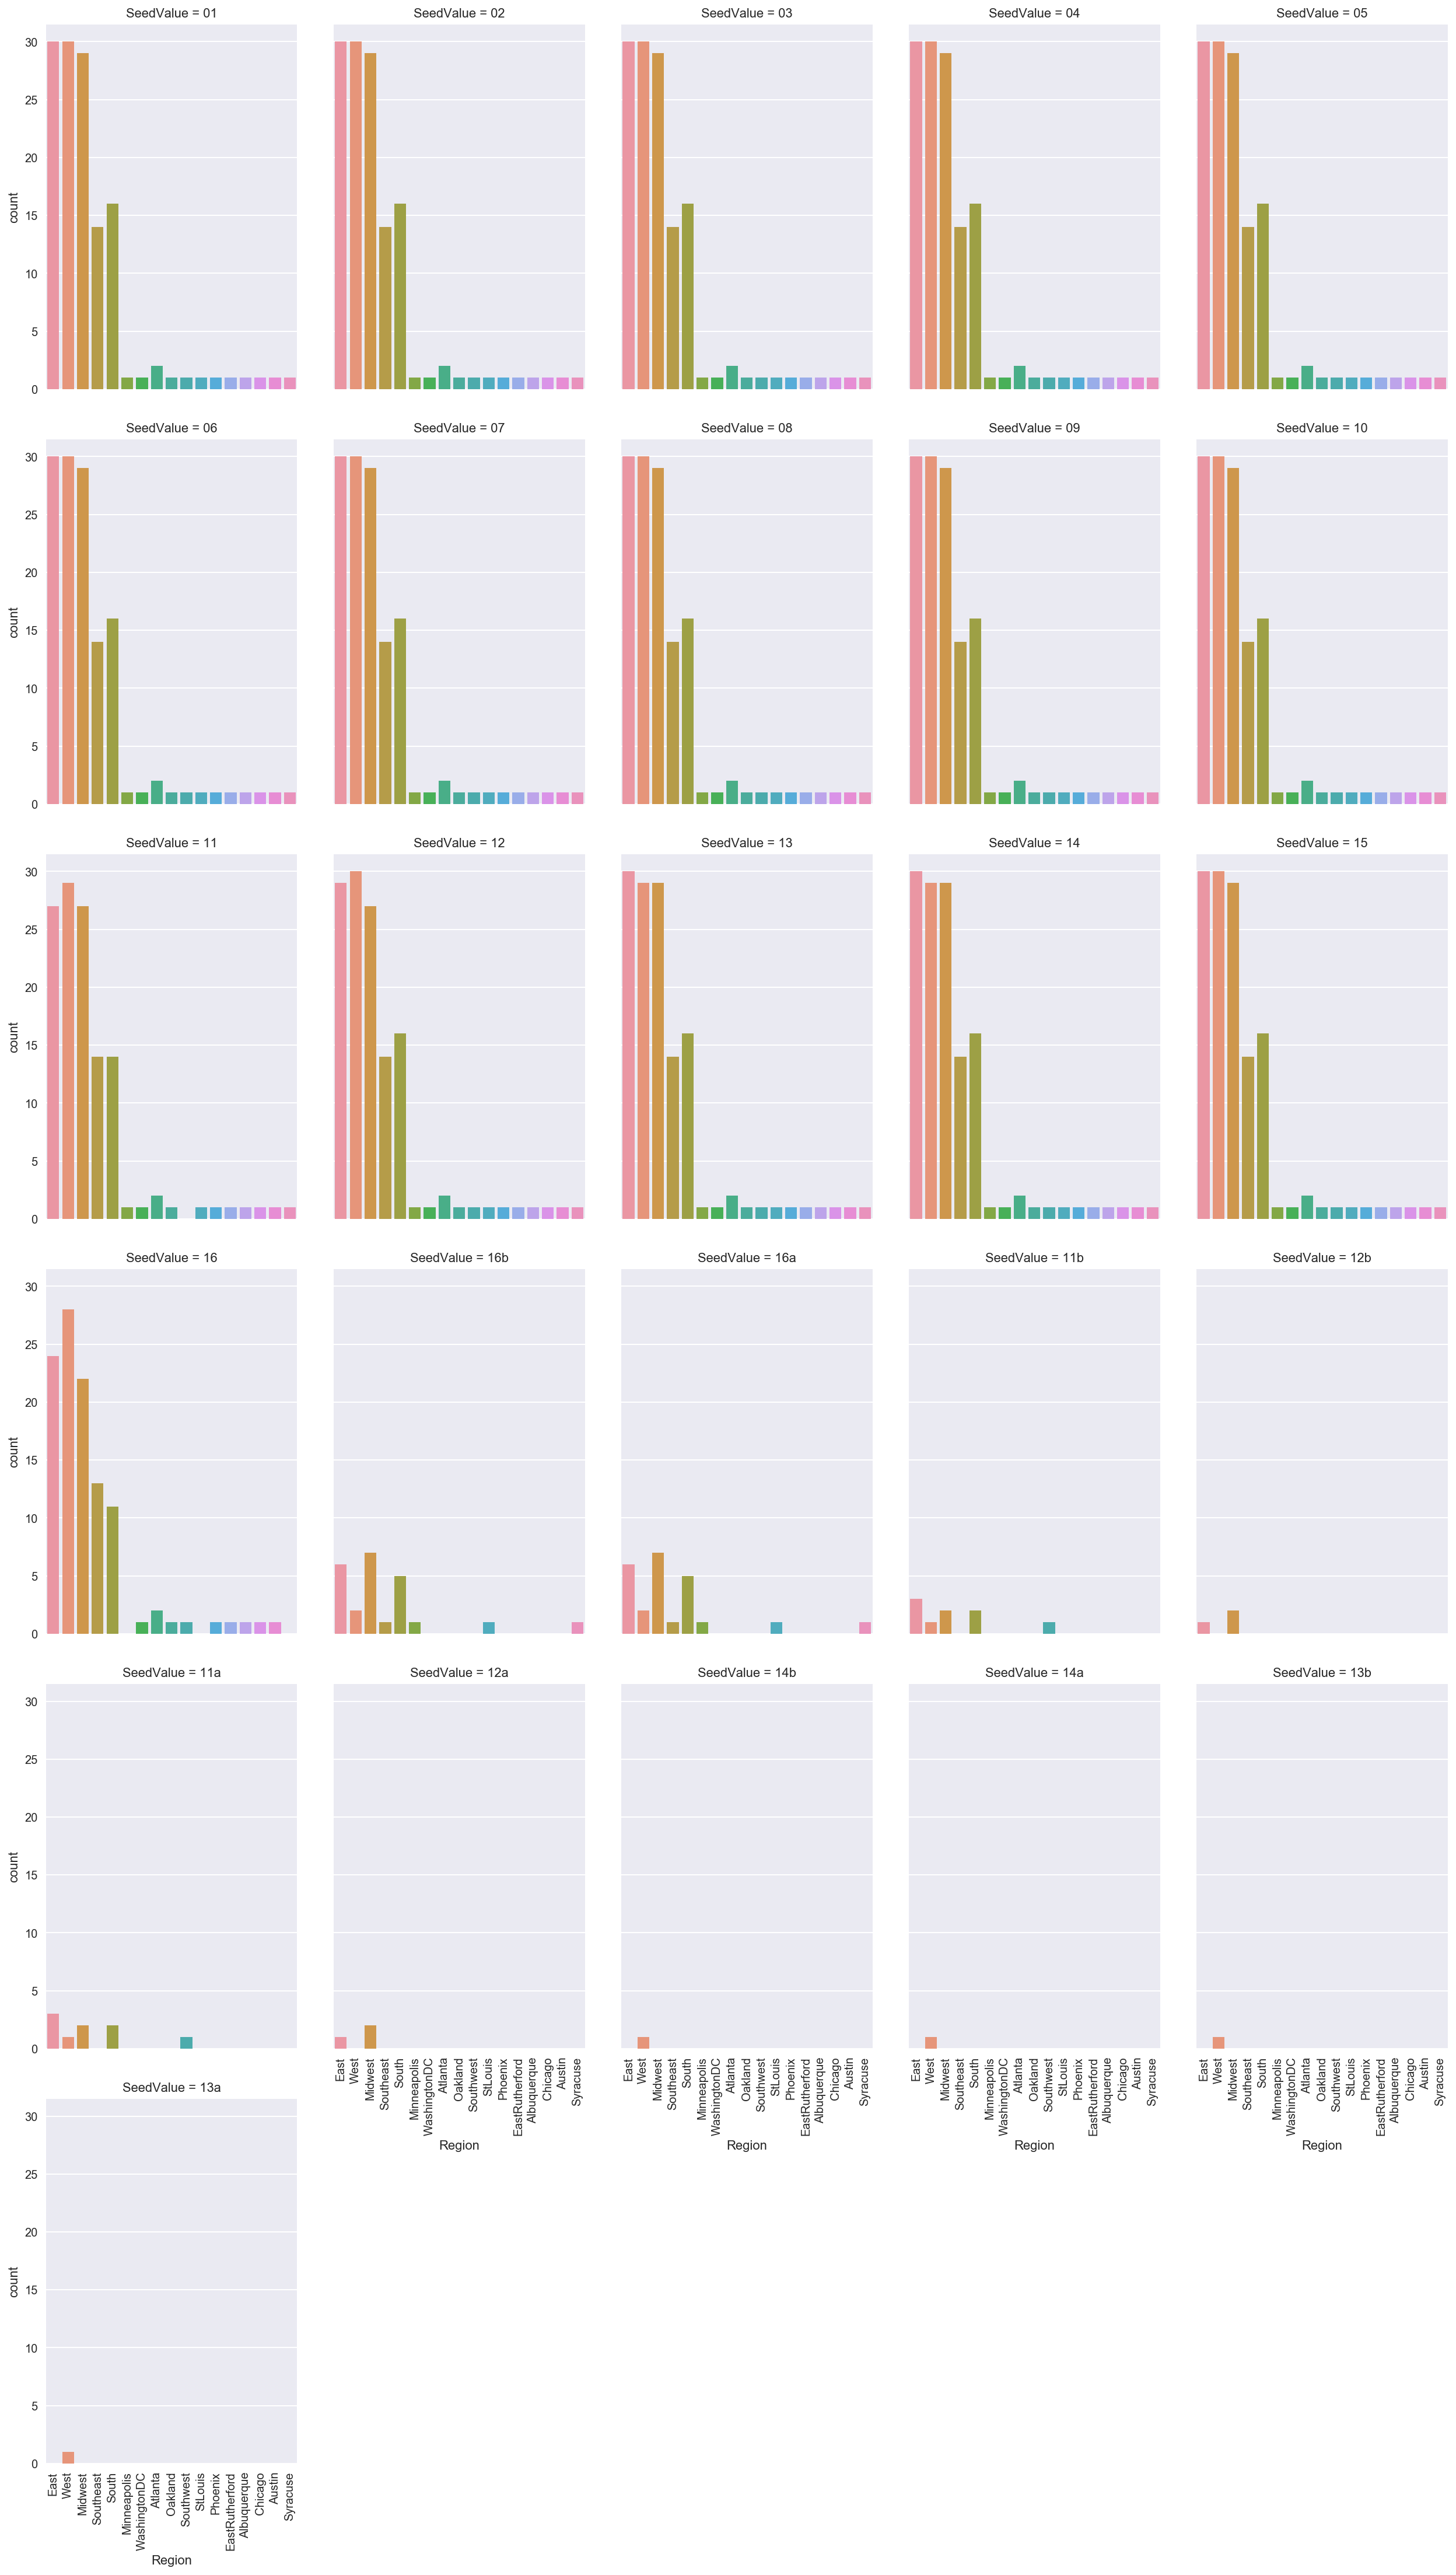

In [18]:
# Regions with what seed value
sns.set(font_scale=1)
g=sns.factorplot(x="Region",col="SeedValue",data=team_history,kind="count",col_wrap = 5,size=5,aspect=.7);
g.set_xticklabels(rotation='vertical');

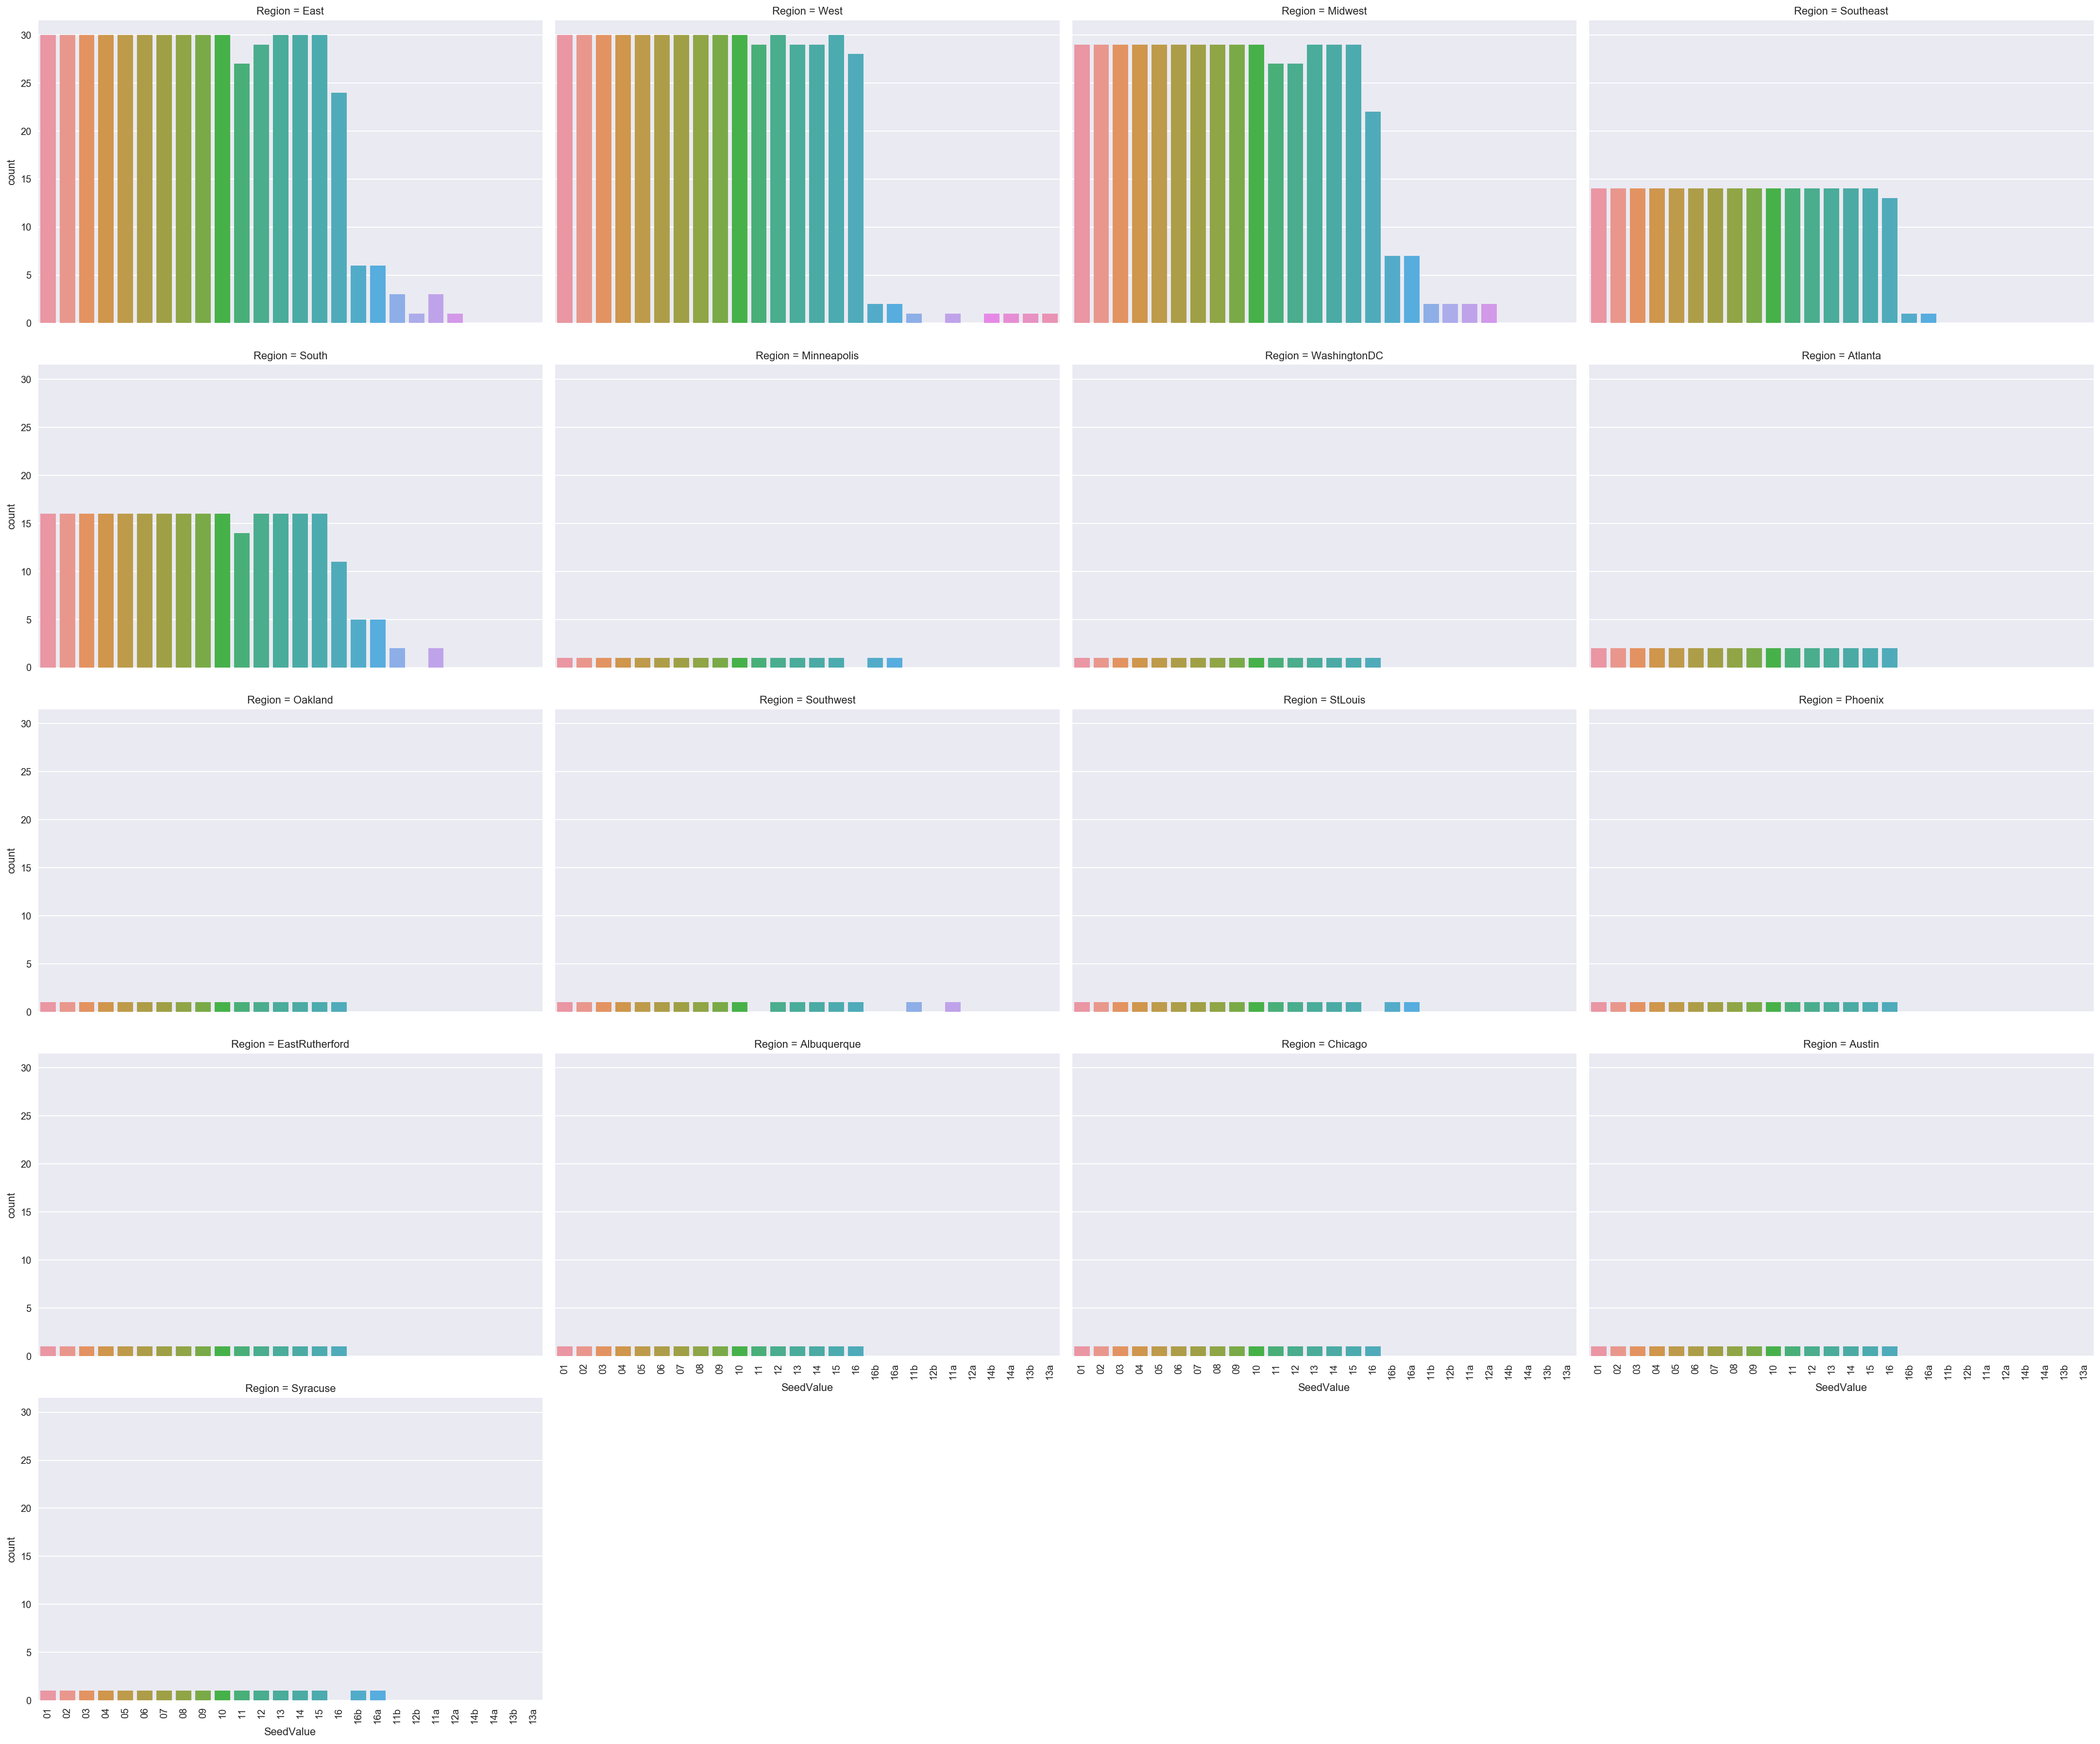

In [19]:
# Seeds for which region
g=sns.factorplot(x="SeedValue",col="Region",data=team_history,dodge=True,kind="count",col_wrap = 4,size=5,aspect=1.5)
g.set_xticklabels(rotation='vertical');

In [20]:
team_list=team_history[['TeamID', 'TeamName']].drop_duplicates().sort_values(by=['TeamID'])

In [21]:
team_list=dict(team_list.values)
team_list

{1102: 'Air Force',
 1103: 'Akron',
 1104: 'Alabama',
 1105: 'Alabama A&M',
 1106: 'Alabama St',
 1107: 'Albany NY',
 1108: 'Alcorn St',
 1110: 'American Univ',
 1111: 'Appalachian St',
 1112: 'Arizona',
 1113: 'Arizona St',
 1114: 'Ark Little Rock',
 1115: 'Ark Pine Bluff',
 1116: 'Arkansas',
 1117: 'Arkansas St',
 1120: 'Auburn',
 1122: 'Austin Peay',
 1123: 'Ball St',
 1124: 'Baylor',
 1125: 'Belmont',
 1127: 'Binghamton',
 1129: 'Boise St',
 1130: 'Boston College',
 1131: 'Boston Univ',
 1133: 'Bradley',
 1135: 'Brown',
 1137: 'Bucknell',
 1138: 'Buffalo',
 1139: 'Butler',
 1140: 'BYU',
 1141: 'C Michigan',
 1142: 'Cal Poly SLO',
 1143: 'California',
 1144: 'Campbell',
 1145: 'Canisius',
 1148: 'Central Conn',
 1149: 'Charleston So',
 1150: 'Charlotte',
 1151: 'Chattanooga',
 1153: 'Cincinnati',
 1155: 'Clemson',
 1156: 'Cleveland St',
 1157: 'Coastal Car',
 1158: 'Col Charleston',
 1159: 'Colgate',
 1160: 'Colorado',
 1161: 'Colorado St',
 1163: 'Connecticut',
 1164: 'Coppin St',


In [22]:
# find regular season records 
reg_results[reg_results['Season']==1985]

In [23]:
rr_1985.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [31]:
list_of_seasons=set(reg_results['Season'].values)

In [35]:
from collections import Counter, defaultdict
cnt = Counter()
standings = {}
for i in list_of_seasons:
    standings[i] = defaultdict(list)
    for key in team_list.keys():
        # some teams are not in every year
        if key in dict(Counter(reg_results[reg_results['Season']==i]['WTeamID'])).keys() and key in dict(Counter(reg_results[reg_results['Season']==i]['LTeamID'])).keys():
            standings[i].update({team_list[key]:list([dict(Counter(reg_results[reg_results['Season']==i]['WTeamID']))[key],dict(Counter(reg_results[reg_results['Season']==i]['LTeamID']))[key]])})

In [166]:
# general standings
print(standings)

{1985: defaultdict(None, {'Duke': [22, 7], 'DePaul': [18, 9], 'Clemson': [15, 12], 'Wagner': [8, 16], 'Michigan St': [19, 9], 'New Orleans': [10, 19], 'Arizona St': [11, 16], 'Ark Little Rock': [17, 13], 'Oklahoma': [25, 5], 'Penn St': [5, 19], 'McNeese St': [14, 10], 'Mississippi': [8, 17], 'Drexel': [10, 18], 'Old Dominion': [18, 11], 'Virginia': [13, 15], 'NC A&T': [16, 8], 'UC Irvine': [11, 17], 'UCF': [9, 17], 'South Alabama': [14, 13], 'Ball St': [13, 16], 'Boston College': [16, 10], 'Arkansas St': [11, 14], 'CS Fullerton': [16, 13], 'Marshall': [19, 12], 'Niagara': [15, 12], 'Colgate': [1, 21], 'Robert Morris': [7, 19], 'Miami OH': [18, 10], 'Portland': [10, 14], 'UT San Antonio': [16, 9], 'E Washington': [8, 15], 'Illinois St': [20, 7], 'Wyoming': [12, 14], 'IL Chicago': [13, 13], 'Virginia Tech': [19, 8], 'S Carolina St': [9, 15], 'Utah St': [16, 11], 'Loyola MD': [14, 13], 'Princeton': [9, 15], 'Northern Arizona': [14, 12], 'Georgia St': [1, 25], 'Northern Iowa': [8, 16], 'Ho

In [56]:
# general win ratio 
winratio = {}
for i in list_of_seasons:
    winratio[i] = defaultdict(list)
    for team in standings[i]:
        winratio[i].update({team:round(standings[i][team][0]/(standings[i][team][0]+standings[i][team][1]),2)})

In [57]:
winratio

{1985: defaultdict(list,
             {'Air Force': 0.21,
              'Akron': 0.39,
              'Alabama': 0.7,
              'Alabama St': 0.42,
              'Alcorn St': 0.76,
              'American Univ': 0.28,
              'Appalachian St': 0.42,
              'Arizona': 0.67,
              'Arizona St': 0.41,
              'Ark Little Rock': 0.57,
              'Arkansas': 0.64,
              'Arkansas St': 0.44,
              'Auburn': 0.62,
              'Austin Peay': 0.26,
              'BYU': 0.52,
              'Ball St': 0.45,
              'Baylor': 0.29,
              'Boise St': 0.48,
              'Boston College': 0.62,
              'Boston Univ': 0.5,
              'Bradley': 0.57,
              'Brown': 0.31,
              'Bucknell': 0.6,
              'Butler': 0.67,
              'C Michigan': 0.25,
              'CS Fullerton': 0.55,
              'California': 0.4,
              'Campbell': 0.09,
              'Canisius': 0.67,
              'Charleston

In [163]:
# for each team record who they played and if they played who won and loss 
matchups = {}
for key in team_list.keys():
    #key=team_list[key]
    matchups[key] = {}
    for i in list_of_seasons: 
        matchups[key][i] = defaultdict(list)
        rr = reg_results[reg_results['Season']==i].reset_index(drop=True)
        rr_W=rr[rr['WTeamID']==key].reset_index(drop=True)
        rr_L=rr[rr['LTeamID']==key].reset_index(drop=True)
        for row in range(len(rr_W)):
            # who they won against
            matchups[key][i]['Won'].append(rr_W['LTeamID'][row])
        for row in range(len(rr_L)):
            # who they lost against
            matchups[key][i]['Lost'].append(rr_L['WTeamID'][row])

In [165]:
# team : year : which teams they lost to, which teams they won against 
print(matchups)

{1102: {1985: defaultdict(<class 'list'>, {'Lost': [1211, 1285, 1382, 1135, 1161, 1361, 1431, 1307, 1461, 1140, 1218, 1361, 1307, 1431, 1428, 1140, 1161, 1428, 1428], 'Won': [1225, 1109, 1461, 1218, 1140]}), 1986: defaultdict(<class 'list'>, {'Lost': [1319, 1225, 1298, 1186, 1211, 1361, 1161, 1431, 1461, 1140, 1428, 1140, 1361, 1307, 1431, 1161, 1461, 1428, 1461], 'Won': [1109, 1119, 1218, 1218, 1307, 1218]}), 1987: defaultdict(<class 'list'>, {'Lost': [1319, 1405, 1457, 1161, 1307, 1140, 1428, 1461, 1461, 1161, 1428, 1431, 1431, 1307, 1140], 'Won': [1109, 1186, 1204, 1361, 1218, 1140, 1218, 1361]}), 1988: defaultdict(<class 'list'>, {'Lost': [1264, 1119, 1226, 1266, 1307, 1431, 1461, 1428, 1428, 1140, 1461, 1431, 1140, 1161, 1218, 1361, 1218], 'Won': [1339, 1310, 1109, 1361, 1218, 1307, 1161]}), 1989: defaultdict(<class 'list'>, {'Lost': [1109, 1462, 1163, 1218, 1361, 1431, 1161, 1140, 1431, 1307, 1161, 1428, 1307, 1307], 'Won': [1434, 1226, 1339, 1172, 1461, 1140, 1428, 1218, 1361, 1

We have more detailed data of which teams beat who and which teams lost to who for every season. We can now look for which teams won more in specific matchups. For example Cal Poly SLO/UCSB or UCLA/USC are rival schools, who won more often? We can look for every match up and calculate the percentages. Then maybe look for differences during March Madness. Some teams might have a playoff buff? Who knows? 

In [ ]:
#